# Proyecto STEAM / EDA ETL

En nuestro rol como data scientist para Steam debemos crear un sistema de recomendacion de videojuegos para la empresa. Debemos limpiar los datasets haciendo un trabajo rapido de `data engineering`. Tener un MVP antes de la fecha de cierre.



Feature Engineering: En el dataset user_reviews se incluyen reseñas de juegos hechos por distintos usuarios. 

Debes crear la columna 'sentiment_analysis' aplicando análisis de sentimiento con NLP con la siguiente escala: 

debe tomar el valor '0' si es malo, '1' si es neutral y '2' si es positivo. Esta nueva columna debe reemplazar la de user_reviews.review para facilitar el trabajo de los modelos de machine learning y el análisis de datos. De no ser posible este análisis por estar ausente la reseña escrita, debe tomar el valor de 1.

### Desarrollo API: Propones disponibilizar los datos de la empresa usando el framework FastAPI. Las consultas que propones son las siguientes:

Debes crear las siguientes funciones para los endpoints que se consumirán en la API, recuerden que deben tener un decorador por cada una (@app.get(‘/’)).

       def userdata( User_id : str ): Debe devolver cantidad de dinero gastado por el usuario, el porcentaje de recomendación en base a reviews.recommend y cantidad de items. `user_items`

    def countreviews( YYYY-MM-DD y YYYY-MM-DD : str ): Cantidad de usuarios que realizaron reviews entre las fechas dadas y, el porcentaje de recomendación de los mismos en base a reviews.recommend. `user_reviews`

    def genre( género : str ): Devuelve el puesto en el que se encuentra un género sobre el ranking de los mismos analizado bajo la columna PlayTimeForever. `user_items`

    def userforgenre( género : str ): Top 5 de usuarios con más horas de juego en el género dado, con su URL y user_id. `user_items`

    def developer( desarrollador : str ): Cantidad de items y porcentaje de contenido Free por año según empresa desarrolladora. Ejemplo de salida: Activision Año Contenido Free 2023 27% 2022 25% xxxx xx%

    def sentiment_analysis( empresa desarrolladora : str ): Según el año de lanzamiento, se devuelve una lista con la cantidad de registros de reseñas de usuarios que se encuentren categorizados con un análisis de sentimiento. `steam_games`

                    Ejemplo de retorno: {Negative = 182, Neutral = 120, Positive = 278}



    Importante
    El MVP tiene que ser una API que pueda ser consumida segun los criterios de API REST o RESTful. Algunas herramientas como por ejemplo, Streamlit, si bien pueden brindar una interfaz de consulta, no cumplen con las condiciones para ser consideradas una API, sin workarounds.

Deployment: Conoces sobre Render y tienes un tutorial de Render que te hace la vida mas fácil :smile: . También podrías usar Railway, o cualquier otro servicio que permita que la API pueda ser consumida desde la web.

### Análisis exploratorio de los datos: (Exploratory Data Analysis-EDA)

Ya los datos están limpios, ahora es tiempo de investigar las relaciones que hay entre las variables del dataset, ver si hay outliers o anomalías (que no tienen que ser errores necesariamente :eyes: ), y ver si hay algún patrón interesante que valga la pena explorar en un análisis posterior. Las nubes de palabras dan una buena idea de cuáles palabras son más frecuentes en los títulos, ¡podría ayudar al sistema de predicción! En esta ocasión vamos a pedirte que no uses librerías para hacer EDA automático ya que queremos que pongas en práctica los conceptos y tareas involucrados en el mismo. Puedes leer un poco más sobre EDA en este articulo
Modelo de aprendizaje automático:

Una vez que toda la data es consumible por la API, está lista para consumir por los departamentos de Analytics y Machine Learning, y nuestro EDA nos permite entender bien los datos a los que tenemos acceso, es hora de entrenar nuestro modelo de machine learning para armar un sistema de recomendación.

Para ello, te ofrecen dos propuestas de trabajo: En la primera, el modelo deberá tener una relación ítem-ítem, esto es se toma un item, en base a que tan similar esa ese ítem al resto, se recomiendan similares. Aquí el input es un juego y el output es una lista de juegos recomendados, para ello recomendamos aplicar la similitud del coseno. La otra propuesta para el sistema de recomendación debe aplicar el filtro user-item, esto es tomar un usuario, se encuentran usuarios similares y se recomiendan ítems que a esos usuarios similares les gustaron. En este caso el input es un usuario y el output es una lista de juegos que se le recomienda a ese usuario, en general se explican como “A usuarios que son similares a tí también les gustó…”. Deben crear al menos uno de los dos sistemas de recomendación (Si se atreven a tomar el desafío, para mostrar su capacidad al equipo, ¡pueden hacer ambos!). Tu líder pide que el modelo derive obligatoriamente en un GET/POST en la API símil al siguiente formato:

Si es un sistema de recomendación item-item:

    def recomendacion_juego( id de producto ): Ingresando el id de producto, deberíamos recibir una lista con 5 juegos recomendados similares al ingresado.

Si es un sistema de recomendación user-item:

    def recomendacion_usuario( id de usuario ): Ingresando el id de un usuario, deberíamos recibir una lista con 5 juegos recomendados para dicho usuario.


In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import gzip 
import ast
import re

import pickle

#from sklearn.model_selection import train_test_split
#from sklearn.linear_model import LinearRegression
#from sklearn.metrics import mean_squared_error

In [3]:
# Cargo el json a un dataframe de la forma mas simple
df = pd.read_json('data/steam_games.json.gz', lines=True, compression='gzip')

In [4]:
df.tail(10)

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
120435,Retro Army Limited,"[Action, Adventure, Indie]",The spy who shot me™,The spy who shot me™,http://store.steampowered.com/app/771810/The_s...,2018-10-01,"[Action, Adventure, Indie]",http://steamcommunity.com/app/771810/reviews/?...,"[Single-player, Captions available]",None,0.0,771810.0,Retro Army Limited
120436,OrtiGames/OrtiSoft,"[Casual, Indie]",Raining blocks,Raining blocks,http://store.steampowered.com/app/767590/Raini...,2018-01-04,"[Indie, Casual]",http://steamcommunity.com/app/767590/reviews/?...,"[Single-player, Shared/Split Screen, Steam Ach...",0.99,0.0,767590.0,"Oscar Ortigueira López,OrtiGames/OrtiSoft"
120437,INGAME,"[Indie, RPG]",Bravium,Bravium,http://store.steampowered.com/app/747320/Bravium/,2018-01-04,"[Indie, RPG, Puzzle, Tower Defense]",http://steamcommunity.com/app/747320/reviews/?...,"[Single-player, Steam Achievements, Steam Lead...",14.99,0.0,747320.0,INGAME
120438,Riviysky,"[Casual, Indie]",BAE 2,BAE 2,http://store.steampowered.com/app/769330/BAE_2/,2018-01-04,"[Indie, Casual]",http://steamcommunity.com/app/769330/reviews/?...,[Single-player],None,0.0,769330.0,Riviysky
120439,Bidoniera Games,"[Action, Adventure, Casual, Indie]",Kebab it Up!,Kebab it Up!,http://store.steampowered.com/app/745400/Kebab...,2018-01-04,"[Action, Indie, Casual, Violent, Adventure]",http://steamcommunity.com/app/745400/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",1.99,0.0,745400.0,Bidoniera Games
120440,Ghost_RUS Games,"[Casual, Indie, Simulation, Strategy]",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"[Strategy, Indie, Casual, Simulation]",http://steamcommunity.com/app/773640/reviews/?...,"[Single-player, Steam Achievements]",1.99,0.0,773640.0,"Nikita ""Ghost_RUS"""
120441,Sacada,"[Casual, Indie, Strategy]",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"[Strategy, Indie, Casual]",http://steamcommunity.com/app/733530/reviews/?...,"[Single-player, Steam Achievements, Steam Clou...",4.99,0.0,733530.0,Sacada
120442,Laush Studio,"[Indie, Racing, Simulation]",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"[Indie, Simulation, Racing]",http://steamcommunity.com/app/610660/reviews/?...,"[Single-player, Steam Achievements, Steam Trad...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich
120443,SIXNAILS,"[Casual, Indie]",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"[Indie, Casual, Puzzle, Singleplayer, Atmosphe...",http://steamcommunity.com/app/658870/reviews/?...,"[Single-player, Steam Achievements, Steam Cloud]",4.99,0.0,658870.0,"xropi,stev3ns"
120444,None,None,Maze Run VR,None,http://store.steampowered.com/app/681550/Maze_...,None,"[Early Access, Adventure, Indie, Action, Simul...",http://steamcommunity.com/app/681550/reviews/?...,"[Single-player, Stats, Steam Leaderboards, HTC...",4.99,1.0,681550.0,None


In [5]:
df.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
0,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
1,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
2,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
3,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None
4,None,None,None,None,None,None,None,None,None,None,NaN,NaN,None


In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24083 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   url           32135 non-null  object 
 5   release_date  30068 non-null  object 
 6   tags          31972 non-null  object 
 7   reviews_url   32133 non-null  object 
 8   specs         31465 non-null  object 
 9   price         30758 non-null  object 
 10  early_access  32135 non-null  float64
 11  id            32133 non-null  float64
 12  developer     28836 non-null  object 
dtypes: float64(2), object(11)
memory usage: 11.9+ MB


In [7]:
df.describe()

,early_access,id
count,32135.000000,3.213300e+04
mean,0.060588,4.517574e+05
std,0.238577,1.827140e+05
min,0.000000,1.000000e+01
25%,0.000000,3.292800e+05
50%,0.000000,4.520600e+05
75%,0.000000,5.934000e+05
max,1.000000,2.028850e+06


In [8]:
# Observamos los valores nulos
df.isnull().sum()

publisher       96362
genres          91593
app_name        88312
title           90360
url             88310
release_date    90377
tags            88473
reviews_url     88312
specs           88980
price           89687
early_access    88310
id              88312
developer       91609
dtype: int64

In [9]:
df['id'].sample()

112163    451130.0
Name: id, dtype: float64

### Exportar como CSV

In [10]:
df.to_csv('steam_games.csv', index=False)

In [14]:
games = pd.read_csv('steam_games.csv')

/tmp/ipykernel_16638/2960884947.py:1: DtypeWarning: Columns (0,1,2,3,4,5,6,7,8,9,12) have mixed types. Specify dtype option on import or set low_memory=False.
  games = pd.read_csv('steam_games.csv')


In [15]:
# Comprobamos que se cargo correctamente
games.tail()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
120440,Ghost_RUS Games,"['Casual', 'Indie', 'Simulation', 'Strategy']",Colony On Mars,Colony On Mars,http://store.steampowered.com/app/773640/Colon...,2018-01-04,"['Strategy', 'Indie', 'Casual', 'Simulation']",http://steamcommunity.com/app/773640/reviews/?...,"['Single-player', 'Steam Achievements']",1.99,0.0,773640.0,"Nikita ""Ghost_RUS"""
120441,Sacada,"['Casual', 'Indie', 'Strategy']",LOGistICAL: South Africa,LOGistICAL: South Africa,http://store.steampowered.com/app/733530/LOGis...,2018-01-04,"['Strategy', 'Indie', 'Casual']",http://steamcommunity.com/app/733530/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,0.0,733530.0,Sacada
120442,Laush Studio,"['Indie', 'Racing', 'Simulation']",Russian Roads,Russian Roads,http://store.steampowered.com/app/610660/Russi...,2018-01-04,"['Indie', 'Simulation', 'Racing']",http://steamcommunity.com/app/610660/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",1.99,0.0,610660.0,Laush Dmitriy Sergeevich
120443,SIXNAILS,"['Casual', 'Indie']",EXIT 2 - Directions,EXIT 2 - Directions,http://store.steampowered.com/app/658870/EXIT_...,2017-09-02,"['Indie', 'Casual', 'Puzzle', 'Singleplayer', ...",http://steamcommunity.com/app/658870/reviews/?...,"['Single-player', 'Steam Achievements', 'Steam...",4.99,0.0,658870.0,"xropi,stev3ns"
120444,NaN,NaN,Maze Run VR,NaN,http://store.steampowered.com/app/681550/Maze_...,NaN,"['Early Access', 'Adventure', 'Indie', 'Action...",http://steamcommunity.com/app/681550/reviews/?...,"['Single-player', 'Stats', 'Steam Leaderboards...",4.99,1.0,681550.0,NaN


##  DROP de Columnas que no usaremos

In [16]:
# Limpieza de columnas que no son relevantes
games.drop(columns=['url', 'reviews_url'], axis=1, inplace=True)

In [17]:
games.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120445 entries, 0 to 120444
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     24073 non-null  object 
 1   genres        28852 non-null  object 
 2   app_name      32133 non-null  object 
 3   title         30085 non-null  object 
 4   release_date  30068 non-null  object 
 5   tags          31972 non-null  object 
 6   specs         31465 non-null  object 
 7   price         30758 non-null  object 
 8   early_access  32135 non-null  float64
 9   id            32133 non-null  float64
 10  developer     28836 non-null  object 
dtypes: float64(2), object(9)
memory usage: 10.1+ MB


# Tags y Specs

In [18]:
# This line replaces any missing values in the 'tags' column of the 'games' dataframe with an empty list.
games['tags'] = games['tags'].fillna('[]')

games['tags'] = games['tags'].apply(lambda x: ast.literal_eval(x))

tag_games = pd.DataFrame(games['tags'].tolist())
tag_games_obj = tag_games.stack()
tag_games_df = pd.get_dummies(tag_games_obj)

In [19]:
tag_games_grouped = tag_games_df.groupby(level= [0], axis= 1 ).sum()

In [20]:
tag_games_grouped.tail()

1980s  1990's  2.5D  2D  2D Fighter  360 Video  3D Platformer  \
120444 1      0       0     0   0           0          0              0   
       2      0       0     0   0           0          0              0   
       3      0       0     0   0           0          0              0   
       4      0       0     0   0           0          0              0   
       5      0       0     0   0           0          0              0   

          3D Vision  4 Player Local  4X  ...  Warhammer 40K  Web Publishing  \
120444 1          0               0   0  ...              0               0   
       2          0               0   0  ...              0               0   
       3          0               0   0  ...              0               0   
       4          0               0   0  ...              0               0   
       5          0               0   0  ...              0               0   

          Werewolves  Western  Word Game  World War I  World War II  \
120444 1           0        0          0            0             0   
       2           0        0          0            0             0   
       3           0        0          0            0             0   
       4           0        0          0            0             0   
       5           0        0          0            0             0   

          Wrestling  Zombies  e-sports  
120444 1          0        0         0  
       2          0        0         0  
       3          0        0         0  
       4          0        0         0  
       5          0        0         0  

[5 rows x 339 columns]

In [30]:
tag_games_grouped.sum().sort_values(ascending=False).head(15)/len(tag_games_grouped)

Indie               0.104119
Action              0.076849
Adventure           0.058093
Casual              0.057549
Simulation          0.045678
Strategy            0.044709
RPG                 0.034976
Singleplayer        0.025681
Free to Play        0.014217
Multiplayer         0.014082
Great Soundtrack    0.013207
Puzzle              0.012474
Early Access        0.011505
2D                  0.011493
Atmospheric         0.011434
dtype: float64

In [31]:
selected_columns = ["Indie", 
                    "Action",
                    "Adventure",
                    "Casual",
                    "Simulation",
                    "Strategy",
                    "RPG",
                    "Singleplayer",
                    "Free to Play",
                    "Multiplayer",
                    "Great Soundtrack",
                    "Puzzle",
                    "Early Access",
                    "2D",
                    "Atmospheric"
                   ]

t = tag_games_grouped[selected_columns]

In [32]:
t

Indie  Action  Adventure  Casual  Simulation  Strategy  RPG  \
88310  0      0       0          0       0           0         1    0   
       1      0       1          0       0           0         0    0   
       2      1       0          0       0           0         0    0   
       3      0       0          0       1           0         0    0   
       4      0       0          0       0           1         0    0   
...         ...     ...        ...     ...         ...       ...  ...   
120444 1      0       0          1       0           0         0    0   
       2      1       0          0       0           0         0    0   
       3      0       1          0       0           0         0    0   
       4      0       0          0       0           1         0    0   
       5      0       0          0       0           0         0    0   

          Singleplayer  Free to Play  Multiplayer  Great Soundtrack  Puzzle  \
88310  0             0             0            0                 0       0   
       1             0             0            0                 0       0   
       2             0             0            0                 0       0   
       3             0             0            0                 0       0   
       4             0             0            0                 0       0   
...                ...           ...          ...               ...     ...   
120444 1             0             0            0                 0       0   
       2             0             0            0                 0       0   
       3             0             0            0                 0       0   
       4             0             0            0                 0       0   
       5             0             0            0                 0       0   

          Early Access  2D  Atmospheric  
88310  0             0   0            0  
       1             0   0            0  
       2             0   0            0  
       3             0   0            0  
       4             0   0            0  
...                ...  ..          ...  
120444 1             0   0            0  
       2             0   0            0  
       3             0   0            0  
       4             0   0            0  
       5             0   0            0  

[169229 rows x 15 columns]

In [33]:
games = pd.concat([games, t], axis = 1)

In [34]:
games = df.dropna()

In [35]:
games.head()

,publisher,genres,app_name,title,url,release_date,tags,reviews_url,specs,price,early_access,id,developer
88310,Kotoshiro,"[Action, Casual, Indie, Simulation, Strategy]",Lost Summoner Kitty,Lost Summoner Kitty,http://store.steampowered.com/app/761140/Lost_...,2018-01-04,"[Strategy, Action, Indie, Casual, Simulation]",http://steamcommunity.com/app/761140/reviews/?...,[Single-player],4.99,0.0,761140.0,Kotoshiro
88311,"Making Fun, Inc.","[Free to Play, Indie, RPG, Strategy]",Ironbound,Ironbound,http://store.steampowered.com/app/643980/Ironb...,2018-01-04,"[Free to Play, Strategy, Indie, RPG, Card Game...",http://steamcommunity.com/app/643980/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free To Play,0.0,643980.0,Secret Level SRL
88312,Poolians.com,"[Casual, Free to Play, Indie, Simulation, Sports]",Real Pool 3D - Poolians,Real Pool 3D - Poolians,http://store.steampowered.com/app/670290/Real_...,2017-07-24,"[Free to Play, Simulation, Sports, Casual, Ind...",http://steamcommunity.com/app/670290/reviews/?...,"[Single-player, Multi-player, Online Multi-Pla...",Free to Play,0.0,670290.0,Poolians.com
88313,彼岸领域,"[Action, Adventure, Casual]",弹炸人2222,弹炸人2222,http://store.steampowered.com/app/767400/2222/,2017-12-07,"[Action, Adventure, Casual]",http://steamcommunity.com/app/767400/reviews/?...,[Single-player],0.99,0.0,767400.0,彼岸领域
88315,Trickjump Games Ltd,"[Action, Adventure, Simulation]",Battle Royale Trainer,Battle Royale Trainer,http://store.steampowered.com/app/772540/Battl...,2018-01-04,"[Action, Adventure, Simulation, FPS, Shooter, ...",http://steamcommunity.com/app/772540/reviews/?...,"[Single-player, Steam Achievements]",3.99,0.0,772540.0,Trickjump Games Ltd


In [36]:
games.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22530 entries, 88310 to 120443
Data columns (total 13 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   publisher     22530 non-null  object 
 1   genres        22530 non-null  object 
 2   app_name      22530 non-null  object 
 3   title         22530 non-null  object 
 4   url           22530 non-null  object 
 5   release_date  22530 non-null  object 
 6   tags          22530 non-null  object 
 7   reviews_url   22530 non-null  object 
 8   specs         22530 non-null  object 
 9   price         22530 non-null  object 
 10  early_access  22530 non-null  float64
 11  id            22530 non-null  float64
 12  developer     22530 non-null  object 
dtypes: float64(2), object(11)
memory usage: 2.4+ MB


### DESARROLLADORES TOP 10

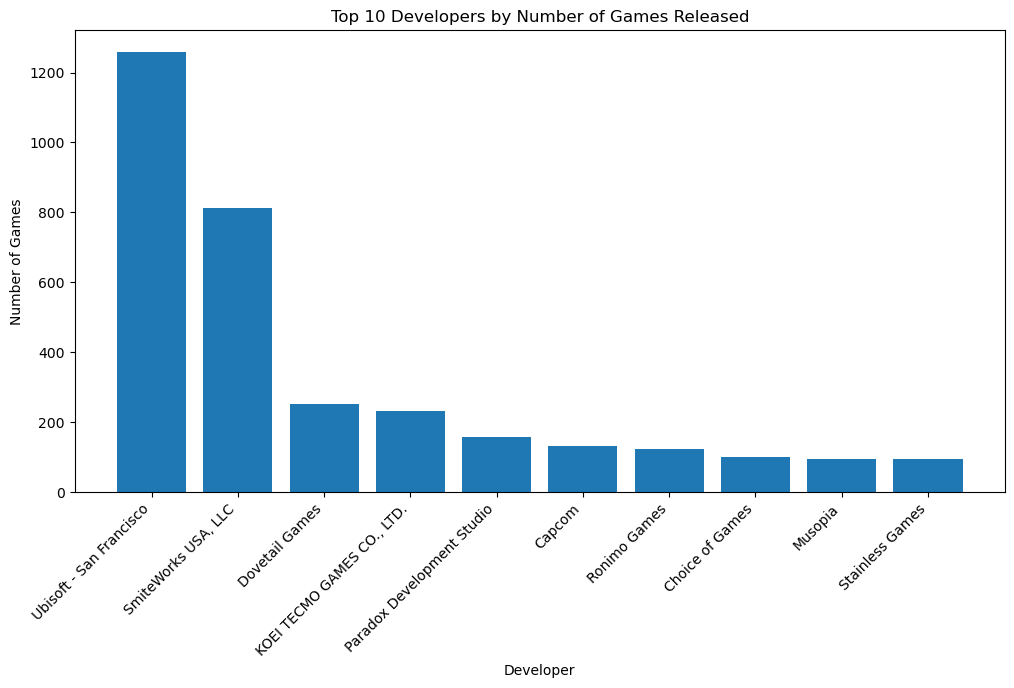

In [5]:
# Group the data by developer and count the number of games for each developer
developer_counts = df['developer'].value_counts().reset_index()
developer_counts.columns = ['Developer', 'Number of Games']

# ordenar nro desarroladores de forma descendente
developer_counts = developer_counts.sort_values(by='Number of Games', ascending=False)

# Elegir top N desarrolladores (e.g., top 10)
top_n = 10
top_developers = developer_counts.head(top_n)


plt.figure(figsize=(12, 6))
plt.bar(top_developers['Developer'], top_developers['Number of Games'])
plt.title(f'Top {top_n} Developers by Number of Games Released')
plt.xlabel('Developer')
plt.ylabel('Number of Games')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for readability

plt.show()